<a href="https://colab.research.google.com/github/Asal-Sanei/MachineLearning2025/blob/main/MiniProject1%20/Part2/FaultDetection/Mafaulda_Time%26FrequencyDomain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installation

# Installation

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!pip install scipy --upgrade
!pip install PyWavelets

#Time Domain Analysis

In [5]:
import os
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert

LABELS = {
    "normal": "A",
    "imbalance": "B",
    "horizontal_misalignment": "C",
    "vertical_misalignment": "D",
    "overhang_ball_fault": "E",
    "overhang_cage_fault": "F",
    "overhang_outer_race": "G",
    "underhang_ball_fault": "H",
    "underhang_cage_fault": "I",
    "underhang_outer_race": "J"
}

file_info = {
    "horizontal_misalignment": "https://drive.google.com/file/d/1Hw4ch_RW3pnGKAx-aBvGWIac7cEZ8QlC/view?usp=sharing",
    "imbalance": "https://drive.google.com/file/d/17Nlcv7VoE45AXNTay9zQowlo--eai03s/view?usp=sharing",
    "normal": "https://drive.google.com/file/d/1kM4-4E7kecWvUv5RfAk_N1tJ-MGNgSpE/view?usp=sharing",
    "overhang_ball_fault": "https://drive.google.com/file/d/1uwzcMK9KblOe4ycXbAsqZwQli2VVtTry/view?usp=sharing",
    "overhang_cage_fault": "https://drive.google.com/file/d/1bxKRUmQy5j7QIC1iyIyHhZM7zIZMymhl/view?usp=sharing",
    "overhang_outer_race": "https://drive.google.com/file/d/1C75FGZps2n2uI2d9yYNZCCNJURrosZTx/view?usp=sharing",
    "underhang_ball_fault": "https://drive.google.com/file/d/1O2hBEm30qlvEGDVJ7Hkm-CIpCZQq_Cat/view?usp=sharing",
    "underhang_cage_fault": "https://drive.google.com/file/d/1z1azPFuiT4lZibOC3OIlE1o8Yozk3vFA/view?usp=sharing",
    "underhang_outer_race": "https://drive.google.com/file/d/12oYeDYNx8wetynEGbpCnlQElsWAZA2ee/view?usp=sharing",
    "vertical_misalignment": "https://drive.google.com/file/d/1PCS3eSYZ4dJYv5n7TiuLFYdto9255wtQ/view?usp=sharing"
}

def read_gdrive_csv(url):
    file_id = url.split('/')[-2]
    download_url = f'https://drive.google.com/uc?id={file_id}&export=download'
    try:
        df = pd.read_csv(download_url, header=None)
        return df
    except Exception as e:
        print(f"Error reading file from {url}: {e}")
        return None

def process_dataframe(df):
    if df.shape[1] <= 2:
        print("DataFrame has too few columns to process after removing the first and last.")
        return None
    df_processed = df.iloc[:, 1:-1].copy()
    if df_processed.empty:
        print("DataFrame is empty after removing the first and last columns.")
        return None
    avg_abs_amplitude = df_processed.abs().mean()
    column_to_remove = avg_abs_amplitude.idxmin()
    df_processed = df_processed.drop(columns=[column_to_remove])
    return df_processed

def apply_sliding_window(df, window_size, stride):
    windows = []
    if len(df) < window_size:
        return windows
    for i in range(0, len(df) - window_size + 1, stride):
        windows.append(df.iloc[i:i + window_size].copy())
    return windows

def extract_features(signal, wavelet='bior3.1', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approx_coeff = coeffs[0]
    detail_coeffs = coeffs[1:]
    features = {}
    # ... (rest of your extract_features function remains the same)
    features = {
        'mean_approx': np.mean(approx_coeff),
        'std_approx': np.std(approx_coeff),
        'var_approx': np.var(approx_coeff),
        'rms_approx': np.sqrt(np.mean(np.square(approx_coeff))),
        'kurt_approx': kurtosis(approx_coeff),
        'skew_approx': skew(approx_coeff),
        'zcr_approx': np.sum(np.abs(np.diff(np.sign(approx_coeff)))) / len(approx_coeff) if len(approx_coeff) > 1 else 0,
        'mcr_approx': np.sum(np.abs(np.diff(np.sign(approx_coeff - np.mean(approx_coeff))))) / len(approx_coeff) if len(approx_coeff) > 1 else 0,
        'entropy_approx': -np.sum(np.histogram(approx_coeff, bins=10, density=True)[0] * np.log2(np.histogram(approx_coeff, bins=10, density=True)[0] + 1e-6))
    }
    for i, d_coeff in enumerate(detail_coeffs, 1):
        features[f'mean_d{i}'] = np.mean(d_coeff)
        features[f'std_d{i}'] = np.std(d_coeff)
        features[f'var_d{i}'] = np.var(d_coeff)
        features[f'rms_d{i}'] = np.sqrt(np.mean(np.square(d_coeff)))
        features[f'kurt_d{i}'] = kurtosis(d_coeff)
        features[f'skew_d{i}'] = skew(d_coeff)
        features[f'entropy_d{i}'] = -np.sum(np.histogram(d_coeff, bins=10, density=True)[0] * np.log2(np.histogram(d_coeff, bins=10, density=True)[0] + 1e-6))
    if len(approx_coeff) > 0:
        analytic_signal = hilbert(approx_coeff)
        features['hilbert_mean'] = np.mean(np.abs(analytic_signal))
        features['hilbert_std'] = np.std(np.abs(analytic_signal))
    else:
        features['hilbert_mean'] = np.nan
        features['hilbert_std'] = np.nan
    return features

def process_single_file(label_name, url, window_size, stride, output_dir="processed_chunks"):
    label = LABELS.get(label_name)
    if not label:
        print(f"Unknown label: {label_name}")
        return

    df = read_gdrive_csv(url)
    if df is None:
        return

    df_processed = process_dataframe(df.copy())
    if df_processed is None:
        return

    windows = apply_sliding_window(df_processed, window_size, stride)
    all_features = []

    for i, window_df in enumerate(windows):
        combined_features = {}
        for col in range(window_df.shape[1]):
            signal = window_df.iloc[:, col].values
            features = extract_features(signal)
            for key, value in features.items():
                combined_features[f'col{col+1}_{key}'] = value
        combined_features['label'] = label
        all_features.append(combined_features)

    if all_features:
        output_filename = os.path.join(output_dir, f"{label_name}_processed.csv")
        os.makedirs(output_dir, exist_ok=True)
        pd.DataFrame(all_features).to_csv(output_filename, index=False)
        print(f"Processed '{label_name}' and saved to '{output_filename}'.")
    else:
        print(f"No windows generated for '{label_name}'.")

if __name__ == "__main__":
    window_size = 2000
    stride = 500
    output_directory = "processed_chunks"

    for label_name, url in file_info.items():
        process_single_file(label_name, url, window_size, stride, output_directory)

    print(f"\nProcessing complete. Processed data saved in '{output_directory}'.")


Processed 'horizontal_misalignment' and saved to 'processed_chunks/horizontal_misalignment_processed.csv'.
Processed 'imbalance' and saved to 'processed_chunks/imbalance_processed.csv'.
Processed 'normal' and saved to 'processed_chunks/normal_processed.csv'.
Processed 'overhang_ball_fault' and saved to 'processed_chunks/overhang_ball_fault_processed.csv'.
Processed 'overhang_cage_fault' and saved to 'processed_chunks/overhang_cage_fault_processed.csv'.
Processed 'overhang_outer_race' and saved to 'processed_chunks/overhang_outer_race_processed.csv'.
Processed 'underhang_ball_fault' and saved to 'processed_chunks/underhang_ball_fault_processed.csv'.
Processed 'underhang_cage_fault' and saved to 'processed_chunks/underhang_cage_fault_processed.csv'.
Processed 'underhang_outer_race' and saved to 'processed_chunks/underhang_outer_race_processed.csv'.
Processed 'vertical_misalignment' and saved to 'processed_chunks/vertical_misalignment_processed.csv'.

Processing complete. Processed data s

In [7]:
     all_processed_data = []
     for filename in os.listdir(output_directory):
         if filename.endswith(".csv"):
             filepath = os.path.join(output_directory, filename)
             df = pd.read_csv(filepath)
             all_processed_data.append(df)

     if all_processed_data:
         final_df = pd.concat(all_processed_data, ignore_index=True)
         final_output_file = "combined_processed_data.csv"
         final_df.to_csv(final_output_file, index=False)
         print(f"\nCombined processed data saved to '{final_output_file}'.")
         print("\nFirst 5 rows of the combined DataFrame:")
         print(final_df.head())


Combined processed data saved to 'combined_processed_data.csv'.

First 5 rows of the combined DataFrame:
   col1_mean_approx  col1_std_approx  col1_var_approx  col1_rms_approx  \
0          0.247210         4.803112        23.069880         4.809469   
1          0.129618         5.204665        27.088539         5.206279   
2          0.977336         3.939243        15.517634         4.058672   
3          0.362239         2.382663         5.677085         2.410042   
4          0.530324         2.243869         5.034950         2.305687   

   col1_kurt_approx  col1_skew_approx  col1_zcr_approx  col1_mcr_approx  \
0         82.946437          8.262963         0.519685         0.551181   
1         84.586597         -8.450561         0.377953         0.377953   
2         64.945974          6.920001         0.503937         0.409449   
3         19.657064         -2.868869         0.598425         0.535433   
4          1.882191         -0.236293         0.425197         0.551181   


--- One-vs-Rest Classification for Original Classes (A to J) ---
Accuracy (One-vs-Rest): 1.0000

Classification Report (One-vs-Rest):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        99
           B       1.00      1.00      1.00        99
           C       1.00      1.00      1.00        99
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00        99
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00        99
           I       1.00      1.00      1.00        99
           J       1.00      1.00      1.00       100

    accuracy                           1.00       994
   macro avg       1.00      1.00      1.00       994
weighted avg       1.00      1.00      1.00       994



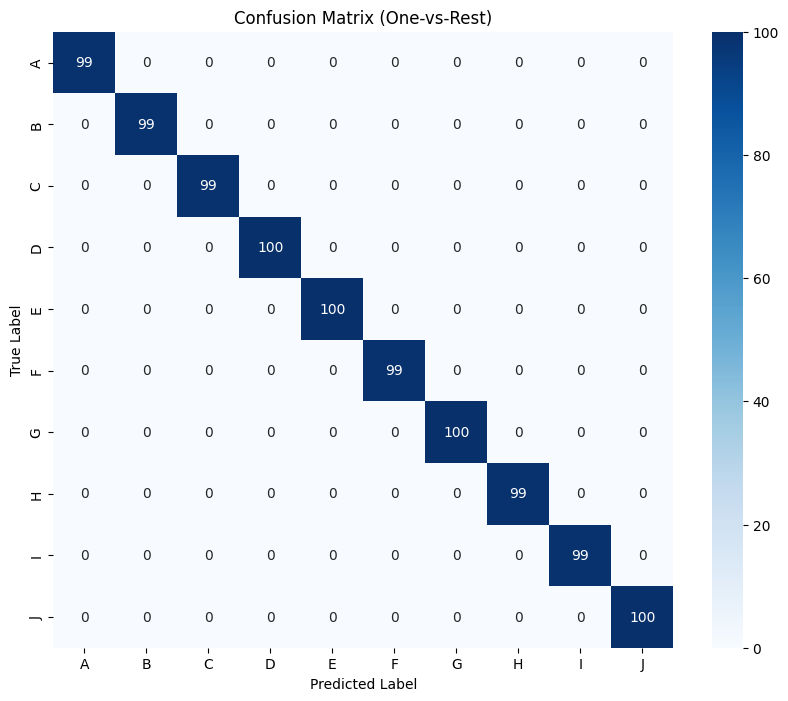


--- One-vs-Rest Classification for Binary (Normal vs Faulty) ---
Accuracy (One-vs-Rest Binary): 1.0000


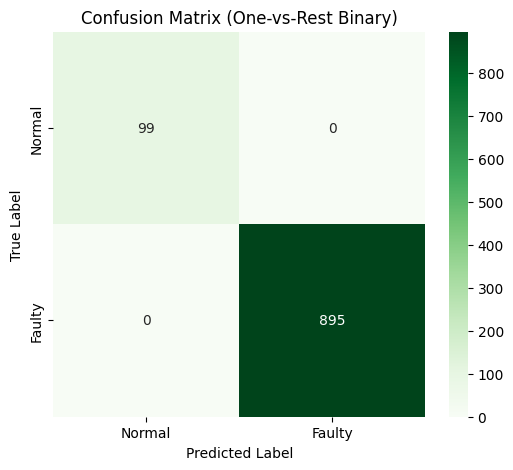


Classification Report (One-vs-Rest Binary):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        99
      Faulty       1.00      1.00      1.00       895

    accuracy                           1.00       994
   macro avg       1.00      1.00      1.00       994
weighted avg       1.00      1.00      1.00       994



In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_processed_data.csv")

X = df.drop(columns=['label'])
y = df['label']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
original_classes = list(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("\n--- One-vs-Rest Classification for Original Classes (A to J) ---")
ovr_classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
ovr_classifier.fit(X_train, y_train_encoded)
y_pred_encoded = ovr_classifier.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

accuracy_ovr = np.mean(y_pred_labels == y_test_labels)
print(f"Accuracy (One-vs-Rest): {accuracy_ovr:.4f}")

print("\nClassification Report (One-vs-Rest):")
print(classification_report(y_test_labels, y_pred_labels))

cm_ovr = confusion_matrix(y_test_labels, y_pred_labels, labels=original_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues', xticklabels=original_classes, yticklabels=original_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (One-vs-Rest)')
plt.show()

print("\n--- One-vs-Rest Classification for Binary (Normal vs Faulty) ---")
y_binary_train = np.where(label_encoder.inverse_transform(y_train_encoded) == "A", 0, 1)
y_binary_test = np.where(label_encoder.inverse_transform(y_test_encoded) == "A", 0, 1)

ovr_classifier_binary = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
ovr_classifier_binary.fit(X_train, y_binary_train)
y_pred_binary = ovr_classifier_binary.predict(X_test)

accuracy_binary_ovr = np.mean(y_pred_binary == y_binary_test)
print(f"Accuracy (One-vs-Rest Binary): {accuracy_binary_ovr:.4f}")

cm_binary_ovr = confusion_matrix(y_binary_test, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary_ovr, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Faulty'], yticklabels=['Normal', 'Faulty'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (One-vs-Rest Binary)')
plt.show()

print("\nClassification Report (One-vs-Rest Binary):")
print(classification_report(y_binary_test, y_pred_binary, target_names=['Normal', 'Faulty']))


--- One-vs-Rest Classification and Confusion Matrix for Each Fault ---

--- Classification for 'Imbalance' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

Other Faults       1.00      1.00      1.00       895
   Imbalance       1.00      1.00      1.00        99

    accuracy                           1.00       994
   macro avg       1.00      1.00      1.00       994
weighted avg       1.00      1.00      1.00       994



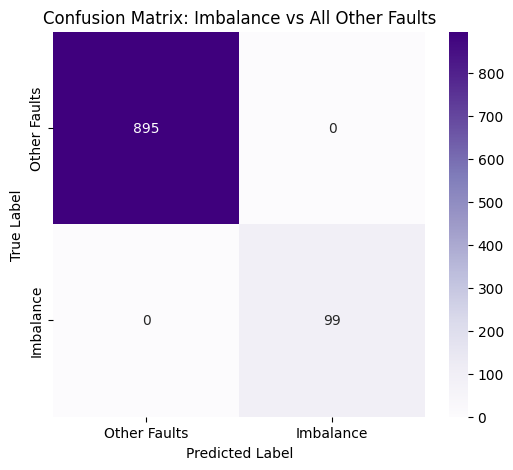


--- Classification for 'Horizontal Misalignment' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                         precision    recall  f1-score   support

           Other Faults       1.00      1.00      1.00       895
Horizontal Misalignment       1.00      1.00      1.00        99

               accuracy                           1.00       994
              macro avg       1.00      1.00      1.00       994
           weighted avg       1.00      1.00      1.00       994



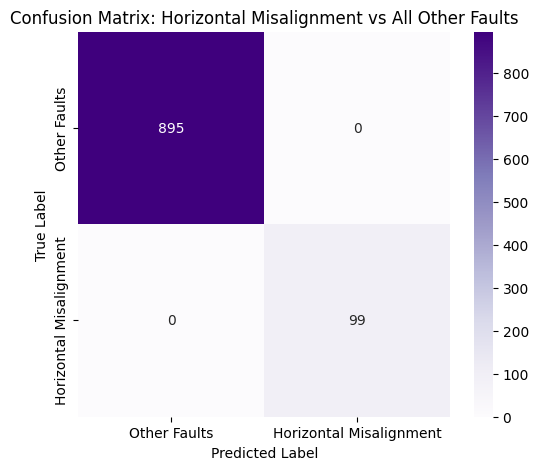


--- Classification for 'Vertical Misalignment' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                       precision    recall  f1-score   support

         Other Faults       1.00      1.00      1.00       895
Vertical Misalignment       1.00      1.00      1.00        99

             accuracy                           1.00       994
            macro avg       1.00      1.00      1.00       994
         weighted avg       1.00      1.00      1.00       994



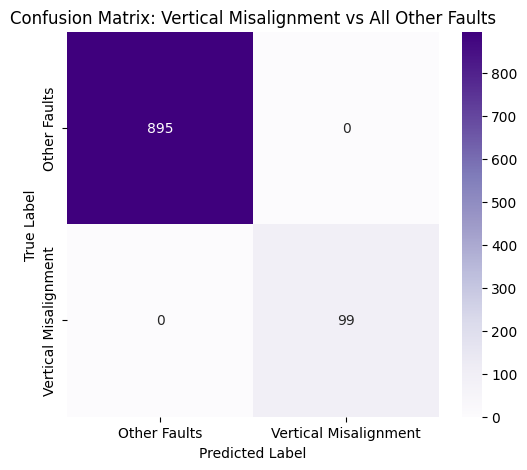


--- Classification for 'Overhang Ball Fault' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                     precision    recall  f1-score   support

       Other Faults       1.00      1.00      1.00       895
Overhang Ball Fault       1.00      1.00      1.00        99

           accuracy                           1.00       994
          macro avg       1.00      1.00      1.00       994
       weighted avg       1.00      1.00      1.00       994



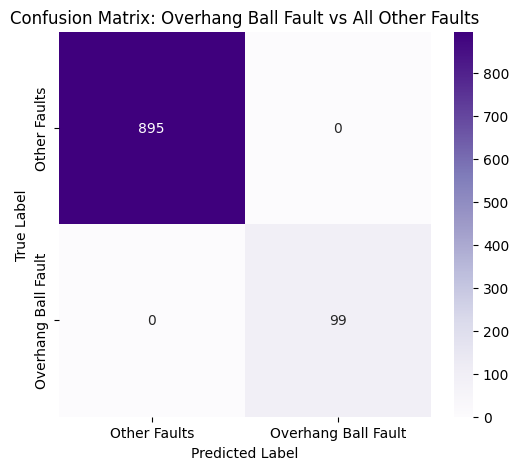


--- Classification for 'Overhang Cage Fault' vs All Other Faults ---
Accuracy: 0.9990

Classification Report:
                     precision    recall  f1-score   support

       Other Faults       1.00      1.00      1.00       895
Overhang Cage Fault       0.99      1.00      0.99        99

           accuracy                           1.00       994
          macro avg       0.99      1.00      1.00       994
       weighted avg       1.00      1.00      1.00       994



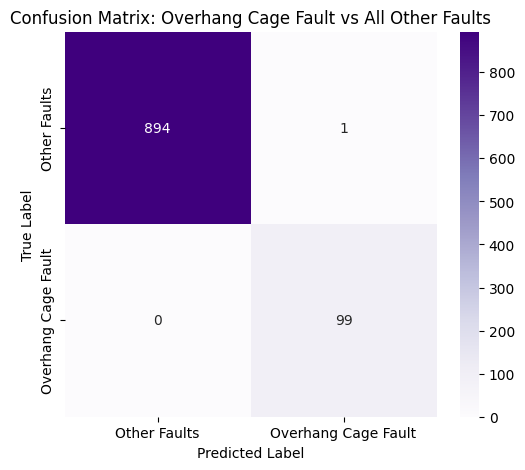


--- Classification for 'Overhang Outer Race' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                     precision    recall  f1-score   support

       Other Faults       1.00      1.00      1.00       895
Overhang Outer Race       1.00      1.00      1.00        99

           accuracy                           1.00       994
          macro avg       1.00      1.00      1.00       994
       weighted avg       1.00      1.00      1.00       994



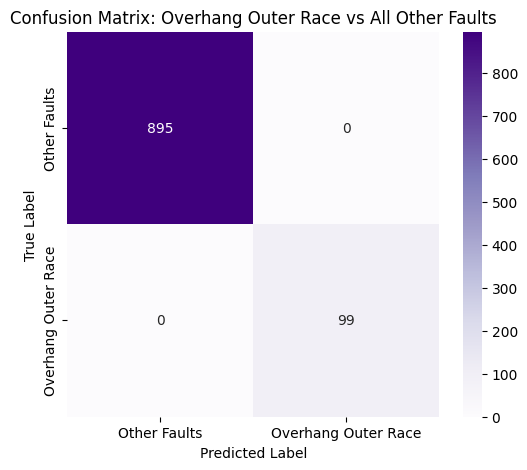


--- Classification for 'Underhang Ball Fault' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                      precision    recall  f1-score   support

        Other Faults       1.00      1.00      1.00       895
Underhang Ball Fault       1.00      1.00      1.00        99

            accuracy                           1.00       994
           macro avg       1.00      1.00      1.00       994
        weighted avg       1.00      1.00      1.00       994



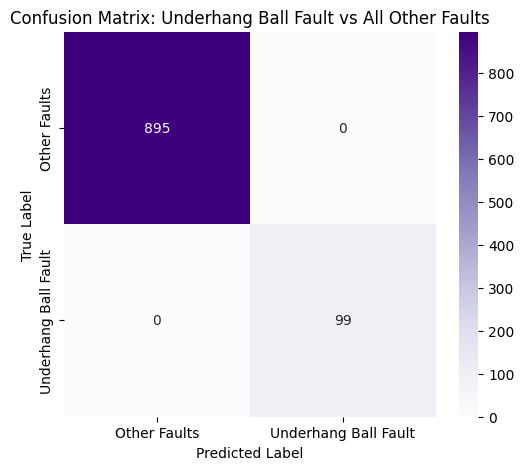


--- Classification for 'Underhang Cage Fault' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                      precision    recall  f1-score   support

        Other Faults       1.00      1.00      1.00       895
Underhang Cage Fault       1.00      1.00      1.00        99

            accuracy                           1.00       994
           macro avg       1.00      1.00      1.00       994
        weighted avg       1.00      1.00      1.00       994



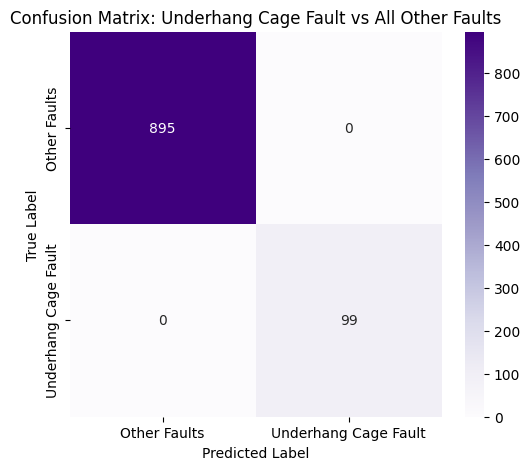


--- Classification for 'Underhang Outer Race' vs All Other Faults ---
Accuracy: 1.0000

Classification Report:
                      precision    recall  f1-score   support

        Other Faults       1.00      1.00      1.00       895
Underhang Outer Race       1.00      1.00      1.00        99

            accuracy                           1.00       994
           macro avg       1.00      1.00      1.00       994
        weighted avg       1.00      1.00      1.00       994



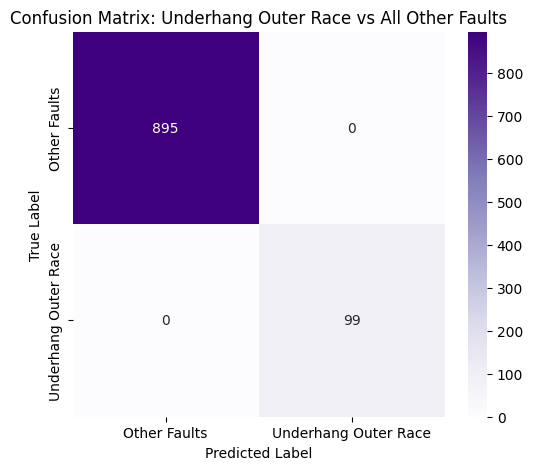

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_processed_data.csv")

X = df.drop(columns=['label'])
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fault_name_mapping = {
    'B': 'Imbalance',
    'C': 'Horizontal Misalignment',
    'D': 'Vertical Misalignment',
    'E': 'Overhang Ball Fault',
    'F': 'Overhang Cage Fault',
    'G': 'Overhang Outer Race',
    'H': 'Underhang Ball Fault',
    'I': 'Underhang Cage Fault',
    'J': 'Underhang Outer Race'
}

fault_labels = sorted([label for label in y.unique() if label != 'A'])

print("\n--- One-vs-Rest Classification and Confusion Matrix for Each Fault ---")

for fault_label in fault_labels:
    full_fault_name = fault_name_mapping.get(fault_label, fault_label)

    y_binary = np.where(y == fault_label, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    ovr_classifier = LogisticRegression(solver='liblinear')
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- Classification for '{full_fault_name}' vs All Other Faults ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Other Faults', full_fault_name]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Other Faults', full_fault_name], yticklabels=['Other Faults', full_fault_name])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {full_fault_name} vs All Other Faults')
    plt.show()

#FFT Analysis

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!pip install scipy --upgrade
!pip install PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.3 MB/s eta 0:00:00


Processed 'horizontal_misalignment' with FFT and saved to 'processed_fft_chunks_for_binary_classification/horizontal_misalignment_fft_processed.csv'.
Processed 'imbalance' with FFT and saved to 'processed_fft_chunks_for_binary_classification/imbalance_fft_processed.csv'.
Processed 'normal' with FFT and saved to 'processed_fft_chunks_for_binary_classification/normal_fft_processed.csv'.
Processed 'overhang_ball_fault' with FFT and saved to 'processed_fft_chunks_for_binary_classification/overhang_ball_fault_fft_processed.csv'.
Processed 'overhang_cage_fault' with FFT and saved to 'processed_fft_chunks_for_binary_classification/overhang_cage_fault_fft_processed.csv'.
Processed 'overhang_outer_race' with FFT and saved to 'processed_fft_chunks_for_binary_classification/overhang_outer_race_fft_processed.csv'.
Processed 'underhang_ball_fault' with FFT and saved to 'processed_fft_chunks_for_binary_classification/underhang_ball_fault_fft_processed.csv'.
Processed 'underhang_cage_fault' with FFT 

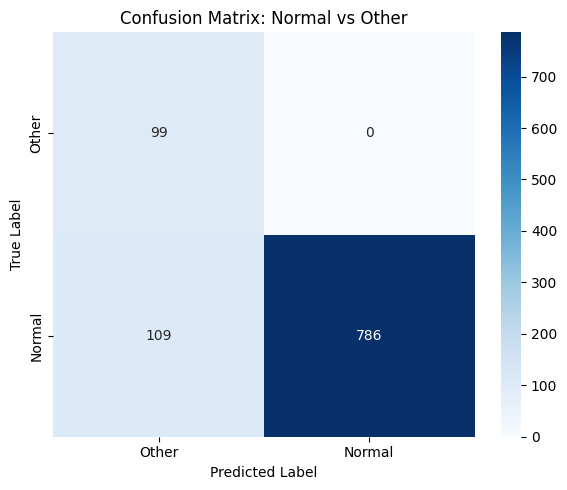


--- Classification: Overhang vs Other ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
    Overhang       1.00      1.00      1.00        99

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



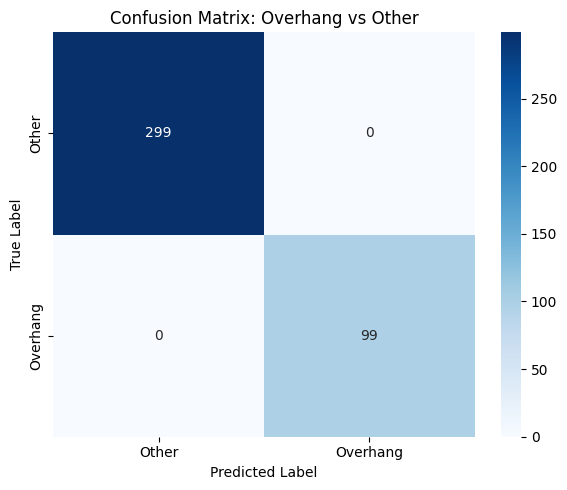


--- Classification: Overhang vs Other ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
    Overhang       1.00      1.00      1.00        99

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



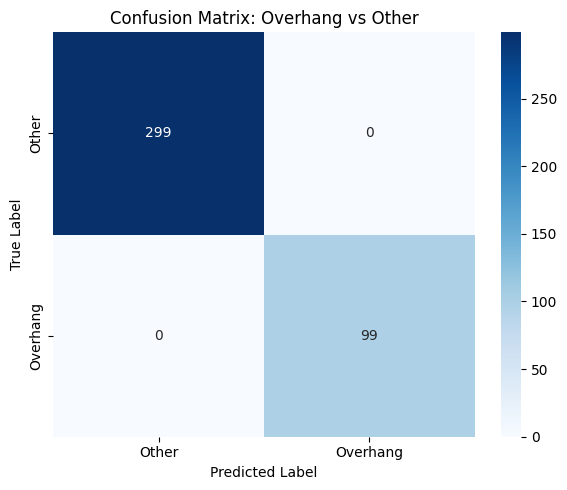


--- Classification: Overhang vs Other ---
Accuracy: 0.9975

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
    Overhang       0.99      1.00      0.99        99

    accuracy                           1.00       398
   macro avg       0.99      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



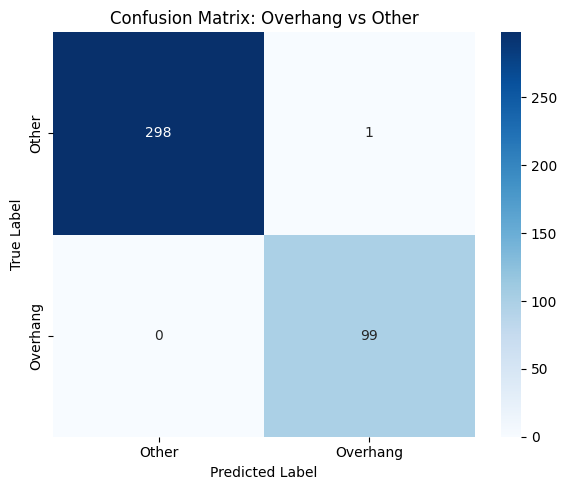


--- Classification: Underhang vs Other ---
Accuracy: 0.9975

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
   Underhang       0.99      1.00      0.99        99

    accuracy                           1.00       398
   macro avg       0.99      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



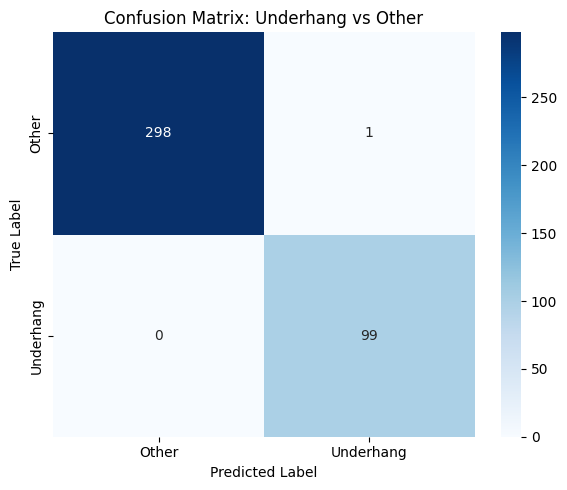


--- Classification: Underhang vs Other ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
   Underhang       1.00      1.00      1.00        99

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



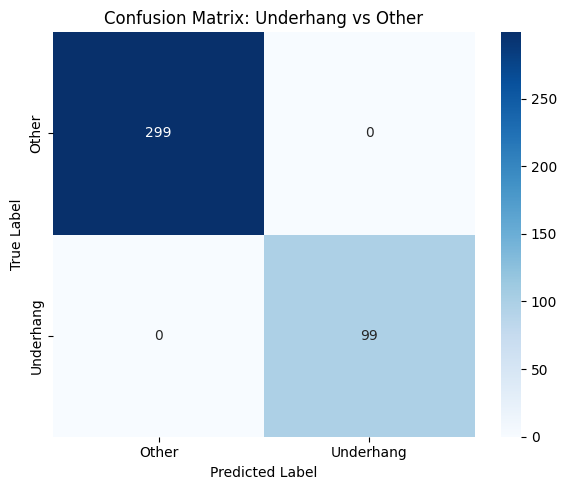


--- Classification: Underhang vs Other ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       299
   Underhang       1.00      1.00      1.00        99

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



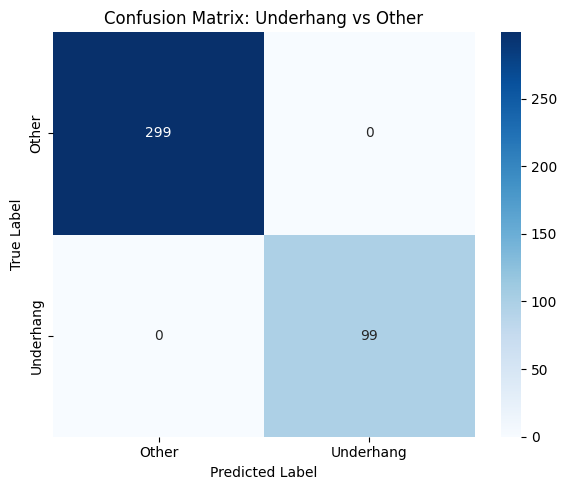


--- Classification: Horizontal Misalignment vs Other ---
Accuracy: 0.9316

Classification Report:
                         precision    recall  f1-score   support

                  Other       0.59      1.00      0.74        99
Horizontal Misalignment       1.00      0.92      0.96       895

               accuracy                           0.93       994
              macro avg       0.80      0.96      0.85       994
           weighted avg       0.96      0.93      0.94       994



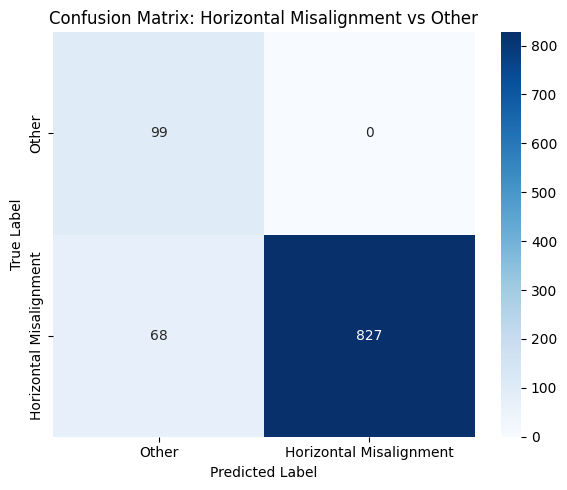


--- Classification: Vertical Misalignment vs Other ---
Accuracy: 0.9245

Classification Report:
                       precision    recall  f1-score   support

                Other       1.00      0.92      0.96       895
Vertical Misalignment       0.57      1.00      0.73        99

             accuracy                           0.92       994
            macro avg       0.78      0.96      0.84       994
         weighted avg       0.96      0.92      0.93       994



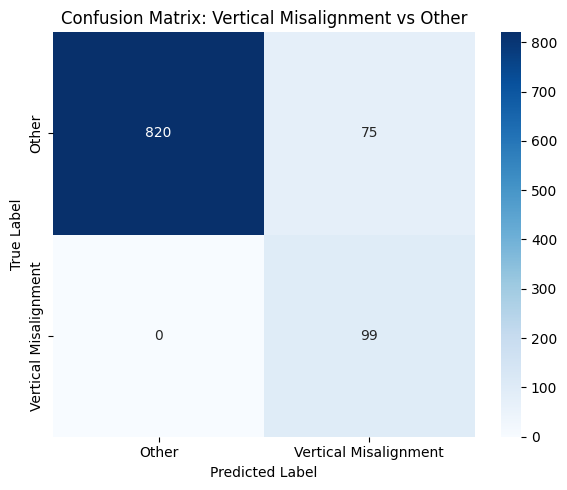


--- Classification: Overhang Outer Race vs Other ---
Accuracy: 0.9920

Classification Report:
                     precision    recall  f1-score   support

              Other       1.00      0.99      1.00       895
Overhang Outer Race       0.93      1.00      0.96        99

           accuracy                           0.99       994
          macro avg       0.96      1.00      0.98       994
       weighted avg       0.99      0.99      0.99       994



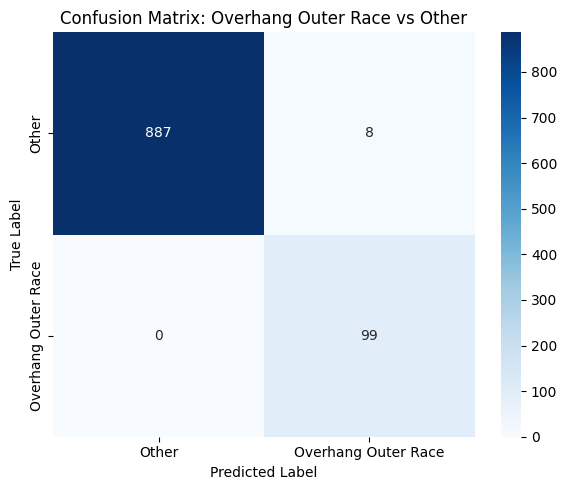


--- Classification: Overhang Ball Fault vs Other ---
Accuracy: 1.0000

Classification Report:
                     precision    recall  f1-score   support

              Other       1.00      1.00      1.00       597
Overhang Ball Fault       1.00      1.00      1.00        99

           accuracy                           1.00       696
          macro avg       1.00      1.00      1.00       696
       weighted avg       1.00      1.00      1.00       696



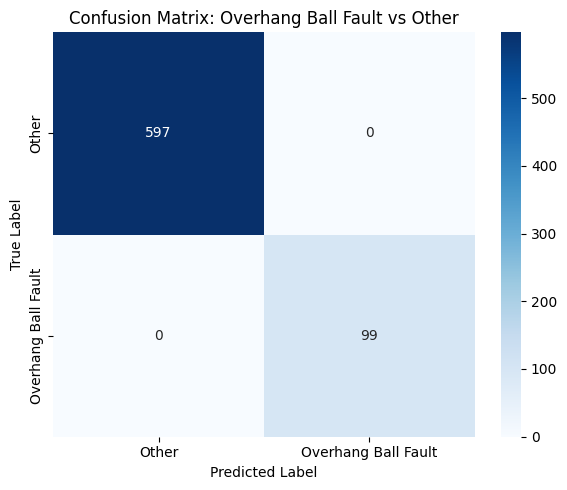


--- Classification: Overhang Cage Fault vs Other ---
Accuracy: 0.9799

Classification Report:
                     precision    recall  f1-score   support

              Other       1.00      0.98      0.99       597
Overhang Cage Fault       0.88      1.00      0.93        99

           accuracy                           0.98       696
          macro avg       0.94      0.99      0.96       696
       weighted avg       0.98      0.98      0.98       696



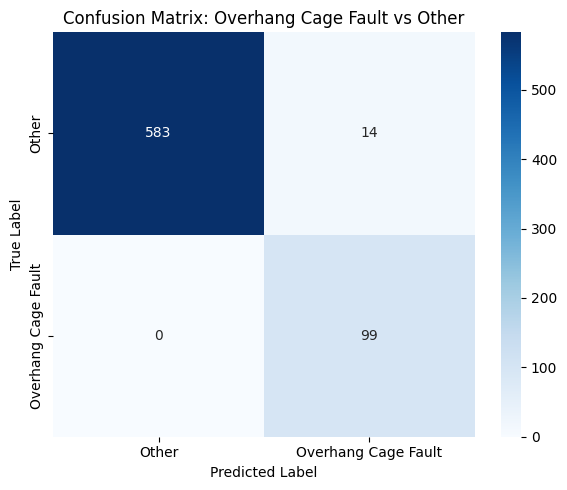


--- Classification: Underhang Outer Race vs Other ---
Accuracy: 0.9920

Classification Report:
                      precision    recall  f1-score   support

               Other       1.00      0.99      1.00       895
Underhang Outer Race       0.93      1.00      0.96        99

            accuracy                           0.99       994
           macro avg       0.96      1.00      0.98       994
        weighted avg       0.99      0.99      0.99       994



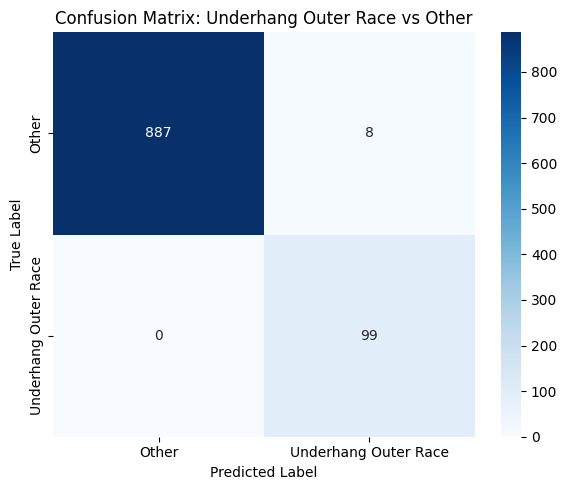


--- Classification: Underhang Ball Fault vs Other ---
Accuracy: 1.0000

Classification Report:
                      precision    recall  f1-score   support

               Other       1.00      1.00      1.00       597
Underhang Ball Fault       1.00      1.00      1.00        99

            accuracy                           1.00       696
           macro avg       1.00      1.00      1.00       696
        weighted avg       1.00      1.00      1.00       696



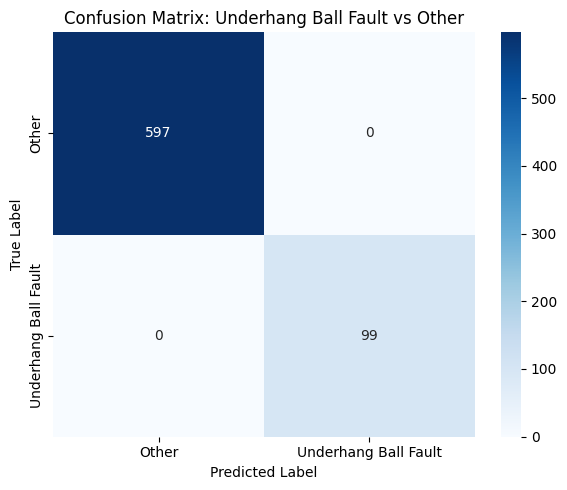


--- Classification: Underhang Cage Fault vs Other ---
Accuracy: 0.9583

Classification Report:
                      precision    recall  f1-score   support

               Other       1.00      0.95      0.98       597
Underhang Cage Fault       0.77      1.00      0.87        99

            accuracy                           0.96       696
           macro avg       0.89      0.98      0.92       696
        weighted avg       0.97      0.96      0.96       696



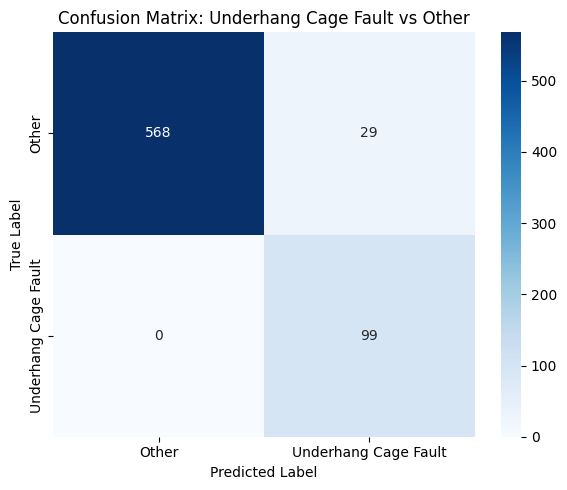


All binary classification tasks completed.


In [4]:
import os
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

LABELS = {
    "normal": "A",
    "imbalance": "B",
    "horizontal_misalignment": "C",
    "vertical_misalignment": "D",
    "overhang_ball_fault": "E",
    "overhang_cage_fault": "F",
    "overhang_outer_race": "G",
    "underhang_ball_fault": "H",
    "underhang_cage_fault": "I",
    "underhang_outer_race": "J"
}

file_info = {
    "horizontal_misalignment": "https://drive.google.com/file/d/1Hw4ch_RW3pnGKAx-aBvGWIac7cEZ8QlC/view?usp=sharing",
    "imbalance": "https://drive.google.com/file/d/17Nlcv7VoE45AXNTay9zQowlo--eai03s/view?usp=sharing",
    "normal": "https://drive.google.com/file/d/1kM4-4E7kecWvUv5RfAk_N1tJ-MGNgSpE/view?usp=sharing",
    "overhang_ball_fault": "https://drive.google.com/file/d/1uwzcMK9KblOe4ycXbAsqZwQli2VVtTry/view?usp=sharing",
    "overhang_cage_fault": "https://drive.google.com/file/d/1bxKRUmQy5j7QIC1iyIyHhZM7zIZMymhl/view?usp=sharing",
    "overhang_outer_race": "https://drive.google.com/file/d/1C75FGZps2n2uI2d9yYNZCCNJURrosZTx/view?usp=sharing",
    "underhang_ball_fault": "https://drive.google.com/file/d/1O2hBEm30qlvEGDVJ7Hkm-CIpCZQq_Cat/view?usp=sharing",
    "underhang_cage_fault": "https://drive.google.com/file/d/1z1azPFuiT4lZibOC3OIlE1o8Yozk3vFA/view?usp=sharing",
    "underhang_outer_race": "https://drive.google.com/file/d/12oYeDYNx8wetynEGbpCnlQElsWAZA2ee/view?usp=sharing",
    "vertical_misalignment": "https://drive.google.com/file/d/1PCS3eSYZ4dJYv5n7TiuLFYdto9255wtQ/view?usp=sharing"
}

def read_gdrive_csv(url):
    file_id = url.split('/')[-2]
    download_url = f'https://drive.google.com/uc?id={file_id}&export=download'
    try:
        df = pd.read_csv(download_url, header=None)
        return df
    except Exception as e:
        print(f"Error reading file from {url}: {e}")
        return None

def process_dataframe(df):
    if df.shape[1] <= 2:
        print("DataFrame has too few columns to process after removing the first and last.")
        return None
    df_processed = df.iloc[:, 1:-1].copy()
    if df_processed.empty:
        print("DataFrame is empty after removing the first and last columns.")
        return None
    avg_abs_amplitude = df_processed.abs().mean()
    column_to_remove = avg_abs_amplitude.idxmin()
    df_processed = df_processed.drop(columns=[column_to_remove])
    return df_processed

def apply_sliding_window(df, window_size, stride):
    windows = []
    if len(df) < window_size:
        return windows
    for i in range(0, len(df) - window_size + 1, stride):
        windows.append(df.iloc[i:i + window_size].copy())
    return windows

def extract_fft_features(signal):
    N = len(signal)
    yf = fft(signal)
    xf = np.fft.fftfreq(N, 1)
    positive_frequencies = yf[0:N//2]
    magnitude_spectrum = np.abs(positive_frequencies)
    phase_spectrum = np.angle(positive_frequencies)
    return np.concatenate([magnitude_spectrum.real, magnitude_spectrum.imag, phase_spectrum.real, phase_spectrum.imag])

def process_single_file(label_name, url, window_size, stride, output_dir="processed_fft_chunks"):
    label = LABELS.get(label_name)
    if not label:
        print(f"Unknown label: {label_name}")
        return

    df = read_gdrive_csv(url)
    if df is None:
        return

    df_processed = process_dataframe(df.copy())
    if df_processed is None:
        return

    windows = apply_sliding_window(df_processed, window_size, stride)
    all_features = []

    for i, window_df in enumerate(windows):
        combined_features = {}
        for col in range(window_df.shape[1]):
            signal = window_df.iloc[:, col].values
            features = extract_fft_features(signal)
            for idx, value in enumerate(features):
                combined_features[f'col{col+1}_fft_{idx}'] = value
        combined_features['label'] = label
        all_features.append(combined_features)

    if all_features:
        output_filename = os.path.join(output_dir, f"{label_name}_fft_processed.csv")
        os.makedirs(output_dir, exist_ok=True)
        pd.DataFrame(all_features).to_csv(output_filename, index=False)
        print(f"Processed '{label_name}' with FFT and saved to '{output_filename}'.")
    else:
        print(f"No windows generated for '{label_name}'.")

def binary_classify_and_report(y_true, y_pred, positive_label_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n--- Classification: {positive_label_name} vs Other ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Other', positive_label_name]))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', positive_label_name], yticklabels=['Other', positive_label_name])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {positive_label_name} vs Other')
    plt.tight_layout()
    plt.show()

def perform_binary_classification(df, target_label, positive_class_name):
    y_binary = np.where(df['label'] == target_label, positive_class_name, 'Other')
    X = df.drop(columns=['label'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    binary_classify_and_report(y_test, y_pred, positive_class_name)

if __name__ == "__main__":
    window_size = 2000
    stride = 500
    output_directory = "processed_fft_chunks_for_binary_classification"
    os.makedirs(output_directory, exist_ok=True)

    all_fft_data = []
    for label_name, url in file_info.items():
        filepath = os.path.join(output_directory, f"{label_name}_fft_processed.csv")
        if not os.path.exists(filepath):
            process_single_file(label_name, url, window_size, stride, output_directory)
        try:
            df = pd.read_csv(filepath)
            all_fft_data.append(df)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")

    if all_fft_data:
        combined_df = pd.concat(all_fft_data, ignore_index=True)
    else:
        print("No FFT processed data available.")
        exit()

    # 1. Normal vs Fault
    perform_binary_classification(combined_df.copy(), 'A', 'Normal')

    # 2. Overhang vs Faults (E, F, G)
    overhang_labels = ['E', 'F', 'G']
    df_overhang = combined_df[combined_df['label'].isin(overhang_labels + ['A'])]
    perform_binary_classification(df_overhang.copy(), 'E', 'Overhang')
    perform_binary_classification(df_overhang.copy(), 'F', 'Overhang')
    perform_binary_classification(df_overhang.copy(), 'G', 'Overhang')

    # 3. Underhang vs Faults (H, I, J)
    underhang_labels = ['H', 'I', 'J']
    df_underhang = combined_df[combined_df['label'].isin(underhang_labels + ['A'])]
    perform_binary_classification(df_underhang.copy(), 'H', 'Underhang')
    perform_binary_classification(df_underhang.copy(), 'I', 'Underhang')
    perform_binary_classification(df_underhang.copy(), 'J', 'Underhang')

    # 4. Horizontal Misalignment vs Faults (C)
    perform_binary_classification(combined_df.copy(), 'C', 'Horizontal Misalignment')

    # 5. Vertical Misalignment vs Faults (D)
    perform_binary_classification(combined_df.copy(), 'D', 'Vertical Misalignment')

    # 6. Overhang Outer Race vs Faults (G)
    perform_binary_classification(combined_df.copy(), 'G', 'Overhang Outer Race')

    # 7. Overhang Ball Fault vs Other Faults (E)
    df_overhang_ball = combined_df[~combined_df['label'].isin(['F', 'G', 'A'])]
    perform_binary_classification(df_overhang_ball.copy(), 'E', 'Overhang Ball Fault')

    # 8. Overhang Cage vs Other Faults (F)
    df_overhang_cage = combined_df[~combined_df['label'].isin(['E', 'G', 'A'])]
    perform_binary_classification(df_overhang_cage.copy(), 'F', 'Overhang Cage Fault')

    # 9. Underhang Outer Race vs Faults (J)
    perform_binary_classification(combined_df.copy(), 'J', 'Underhang Outer Race')

    # 10. Underhang Ball Fault vs Other Faults (H)
    df_underhang_ball = combined_df[~combined_df['label'].isin(['I', 'J', 'A'])]
    perform_binary_classification(df_underhang_ball.copy(), 'H', 'Underhang Ball Fault')

    # 11. Underhang Cage vs Other Faults (I)
    df_underhang_cage = combined_df[~combined_df['label'].isin(['H', 'J', 'A'])]
    perform_binary_classification(df_underhang_cage.copy(), 'I', 'Underhang Cage Fault')

    print("\nAll binary classification tasks completed.")